In [1]:
import xarray as xr
import numpy as np
import os

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pprint

%matplotlib inline

In [2]:
from cdo import *
cdo = Cdo(tempdir='/scratch/k/k202141/cdotmp')

## Figure settings

https://www.geoscientific-model-development.net/submission.html#figurestables

Colour schemes: it is important that the colour schemes used in your maps and charts allow readers with colour vision deficiencies to correctly interpret your findings. Please check your figures using the Coblis – Color Blindness Simulator and revise the colour schemes accordingly.
Figure composition: it is important for the production process that separate figures are submitted. Composite figures containing multiple panels should be collected into one file before submission. The figures should be labelled correctly with Arabic numerals (e.g. f01, f02, ..., f11). They can be submitted in *.pdf, *.ps, *.eps, *.jpg, *.png, or *.tif format and should have a resolution of 300 dpi. The width should not be less than 8 cm. A legend should clarify all symbols used and should appear in the figure itself, rather than verbal explanations in the captions (e.g. "dashed line" or "open green circles"). You are kindly asked to find the best balance between quality of figures (and submitted material) and overall file size. Individual figures should not exceed 5 MB, and the overall size of all submitted files excluding supplements should not exceed 30 MB. The produced paper file will contain all figures in *.jpg or *.png format. However, if authors use vector graphics, readers can download such files labelled "high-resolution" from the full-text HTML version online. Tips for producing high-quality line graphics:

    The first choice should be vector graphics in *.eps or *.pdf format. Fonts must be embedded. Please make sure that the *.pdf files do not contain hidden objects. If you want to adjust fonts in your original figure file before converting into *.pdf, please make sure that you change the actual font of the original figure rather than adding text boxes or other additional layers.
    Please use only one font family in your figures (e.g. Arial or Helvetica) and consider using sans-serif fonts. Keep in mind that the usage of regular, italic, bold, and bold-italic of one font family already leads to four different fonts that must be embedded or adjusted by our image processors in case of text corrections within figures.
    If the processing of your vector figures requires an exceptional amount of time due to multiple fonts or hidden objects, we reserve the right to convert your *.eps or *.pdf figures into *.png files for the further production process.
    If the usage of vector graphics is not possible, a bitmap image should be saved in a "non-lossy" format (e.g. *.png). A high quality is recommended. It is always possible to reduce the size of the figure later.
    The *.jpg format should only be used for photos. It is not suitable for sharp edges. Note that it is not advisable to convert a *.jpg file back to *.png. If *.jpg files must be used please save them with high quality.
    If you are not able to fulfil the above-mentioned criteria, it is also possible to submit figures produced with Excel, PowerPoint, Word, Photoshop, Illustrator, or InDesign in the original file format. Our image processors will then produce the figures from these source files.

The abbreviation "Fig." should be used when it appears in running text and should be followed by a number unless it comes at the beginning of a sentence, e.g.: "The results are depicted in Fig. 5. Figure 9 reveals that...".
Figure content guidelines: in order to facilitate consistency with our language and typesetting guidelines applied to the text of the manuscript, please keep the following in mind when producing your figures:

    Labels of panels must be included with brackets around letters being lower case (e.g. (a), (b), etc.).
    Ranges need an en dash and no spaces between start and end (e.g. 1–10, Jan–Feb).
    Coordinates need a degree sign and a space when naming the direction (e.g. 30° N, 25° E).
    Spaces must be included between number and unit (e.g. 1 %, 1 m).
    Units must be written exponentially (e.g. W m–2).
    Common abbreviations to be applied: hour as h (not hr), kilometre as km, metre as m.
    Capitalization: only the first word is capitalized in headers (in addition to proper nouns). More guidelines are provided in section English guidelines and house standards.



In [3]:
21.5 - 5

16.5

In [4]:
sns.set_context('paper')
sns.set_style('whitegrid')

figwidth = 8.0 # half a DIN A4 paper width
figsize_single = (figwidth/2.51, figwidth/2.51/1.61)
figsize_double = (2 * figwidth/2.51, 2* figwidth/2.51/2.2)
dpi = 300

In [5]:
c_bulk = 'C0' # color for bulk moment scheme lines
c_snet = 'C3' # color for superdropnet lines
l_bulk = 'Bulk moment' # label for bulk moment
l_snet = 'SuperdropNet'       # label for superdropnet
lw = 2 # line width

## Helper functions

In [6]:
def get_time_mins(cdo_array):
    '''
    Returns the time stamps in minutes from a cdo xarray
    
    Simulation time stamp: %Y%m%d.%f
    
    We retrieve the fraction %f and convert it 
    back to minutes    
    '''
    
    time = cdo_array.time.values
    time -= time[0]
    time *= 24 * 60 # time steps in minutes
    
    return time


In [7]:
def get_geometric_height(infile):
    zg = cdo.fldmean(input='-selname,' + 'zg' + ' ' + infile, returnXArray='zg').squeeze().values
    return zg

In [8]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

## Figures

### Grid- and vertically integrated hydrometeor content over time

In [9]:
def compare_grid_vert_int_content_time(value, 
                                       exp_bulkmoment='warm_bubble_fortran', 
                                       exp_superdropnet='warm_bubble_cffi', 
                                       exp_root='/work/ka1176/caroline/gitlab/icon-aes/experiments/',
                                       background=None,
                                       ls1='-', ls2='--',
                                       ylabel=None):
    '''
    Compare the grid integrated content for two experiments
    
    Args:
      value (str): quantity to plot
      exp_bulkmoment: the bulk-moment experiment (default: warm_bubble_fortran)
      exp_superdropnet: the SuperdropNet experiment (default: warm_bubble_cffi)
      exp_root: the experiment root directory (default: /work/ka1176/caroline/gitlab/icon-aes/experiments/)
      background (str): choice of 'bulk-moment-rain' 'superdropnet-rain' None
      ls1, ls2 (str): linestyles (default: - i.e. solid line)
      ylabel (str): axis ylabel, if None construct from data

    '''
    
    fig = plt.figure(figsize=figsize_single)
    ax = fig.add_subplot(111)

    infile_fortran = os.path.join(exp_root, exp_bulkmoment, f'{exp_bulkmoment}_atm_2d_ml_20080801T000000Z.nc')
    infile_cffi    = os.path.join(exp_root, exp_superdropnet, f'{exp_superdropnet}_atm_2d_ml_20080801T000000Z.nc')
    
    q_fortran = cdo.fldint(input=f'-selname,{value} ' + infile_fortran, returnXArray=value).squeeze()
    q_cffi = cdo.fldint(input=f'-selname,{value} ' + infile_cffi, returnXArray=value).squeeze()

    time_fortran = get_time_mins(q_fortran)
    time_cffi    = get_time_mins(q_cffi)

    if ylabel is None:
        ylabel = f'{q_fortran.long_name} ({q_fortran.units})'
        ylabel = ylabel[0].upper() + ylabel[1:]

    ax.plot(time_fortran, q_fortran, lw=lw, color=c_bulk, label=l_bulk, ls=ls1)
    ax.plot(time_cffi, q_cffi, lw=lw,  color=c_snet, label=l_snet, ls=ls2)
    
    if background is None:
        pass
    elif background == 'bulk-moment-rain':
        # include the bulk moment rain in the background
        bm_rain = cdo.fldint(input='-selname,qrvi ' + infile_fortran, returnXArray='qrvi').squeeze()
        ax2 = plt.twinx(ax)
        ax2.grid(False)
        ax2.fill_between(time_fortran, bm_rain, alpha=1.0, color='#d3d3d3')
        ax2.set_yticks([])
        ax.set_zorder(ax2.get_zorder()+1)
        ax.set_frame_on(False)
    elif background == 'superdropnet-rain':
        pass
    else:
        raise ValueError(f'Invalid background: {background}')

    ax.legend()
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(formatter) 

    ax.set_xlim(0, 120)

    print(f'./paper_plots/int_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf')
    plt.savefig(f'./paper_plots/int_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf', dpi=dpi, bbox_inches='tight')

In [10]:
def compare_grid_vert_mean_content_time(value, 
                                       exp_bulkmoment='warm_bubble_fortran', 
                                       exp_superdropnet='warm_bubble_cffi', 
                                       exp_root='/work/ka1176/caroline/gitlab/icon-aes/experiments/',
                                       background=None,
                                        ls1='-', ls2='--',
                                       ylabel=None):
    '''
    Compare the grid averaged content for two experiments
    
    Args:
      value (str): quantity to plot
      exp_bulkmoment: the bulk-moment experiment (default: warm_bubble_fortran)
      exp_superdropnet: the SuperdropNet experiment (default: warm_bubble_cffi)
      exp_root: the experiment root directory (default: /work/ka1176/caroline/gitlab/icon-aes/experiments/)
      background (str): choice of 'bulk-moment-rain' 'superdropnet-rain' None
      ylabel (str): axis ylabel, if None construct from data

    '''
    
    fig = plt.figure(figsize=figsize_single)
    ax = fig.add_subplot(111)

    infile_fortran = os.path.join(exp_root, exp_bulkmoment, f'{exp_bulkmoment}_atm_2d_ml_20080801T000000Z.nc')
    infile_cffi    = os.path.join(exp_root, exp_superdropnet, f'{exp_superdropnet}_atm_2d_ml_20080801T000000Z.nc')
    
    q_fortran = cdo.fldmean(input=f'-selname,{value} ' + infile_fortran, returnXArray=value).squeeze()
    q_cffi = cdo.fldmean(input=f'-selname,{value} ' + infile_cffi, returnXArray=value).squeeze()

    time_fortran = get_time_mins(q_fortran)
    time_cffi    = get_time_mins(q_cffi)

    if ylabel is None:
        ylabel = f'{q_fortran.long_name} ({q_fortran.units})'
        ylabel = ylabel[0].upper() + ylabel[1:]

    ax.plot(time_fortran, q_fortran, lw=lw, color=c_bulk, label=l_bulk, ls=ls1)
    ax.plot(time_cffi, q_cffi, lw=lw,  color=c_snet, label=l_snet, ls=ls2)
    
    if background is None:
        pass
    elif background == 'bulk-moment-rain':
        # include the bulk moment rain in the background
        bm_rain = cdo.fldint(input='-selname,qrvi ' + infile_fortran, returnXArray='qrvi').squeeze()
        ax2 = plt.twinx(ax)
        ax2.grid(False)
        ax2.fill_between(time_fortran, bm_rain, alpha=1.0, color='#d3d3d3')
        ax2.set_yticks([])
        ax.set_zorder(ax2.get_zorder()+1)
        ax.set_frame_on(False)
    elif background == 'superdropnet-rain':
        pass
    else:
        raise ValueError(f'Invalid background: {background}')

    ax.legend()
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(formatter) 

    ax.set_xlim(0, 120)

    print(f'./paper_plots/mean_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf')
    plt.savefig(f'./paper_plots/mean_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf', dpi=dpi, bbox_inches='tight')

Specific rain content, warm bubble scenario

./paper_plots/int_qrvi_warm_bubble_fortran_warm_bubble_cffi.pdf


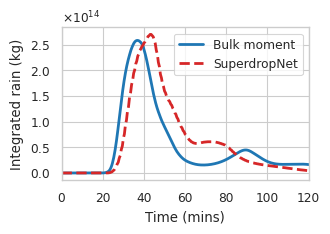

In [11]:
compare_grid_vert_int_content_time('qrvi', ylabel='Integrated rain (kg)')

./paper_plots/mean_qrvi_warm_bubble_fortran_warm_bubble_cffi.pdf


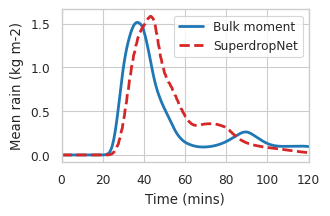

In [12]:
# FIG 1
compare_grid_vert_mean_content_time('qrvi', ylabel='Mean rain (kg m-2)')

Evaporation

./paper_plots/int_evspsbl_warm_bubble_fortran_warm_bubble_cffi.pdf


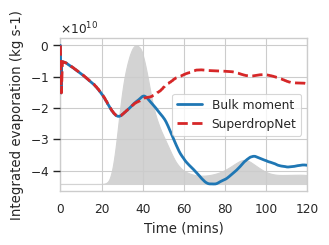

In [13]:
compare_grid_vert_int_content_time('evspsbl', ylabel='Integrated evaporation (kg s-1)', background='bulk-moment-rain')

./paper_plots/mean_evspsbl_warm_bubble_fortran_warm_bubble_cffi.pdf


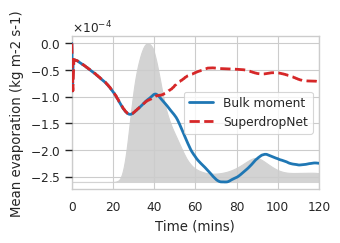

In [14]:
# FIG 4a
compare_grid_vert_mean_content_time('evspsbl', ylabel='Mean evaporation (kg m-2 s-1)', background='bulk-moment-rain')

./paper_plots/int_hfls_warm_bubble_fortran_warm_bubble_cffi.pdf


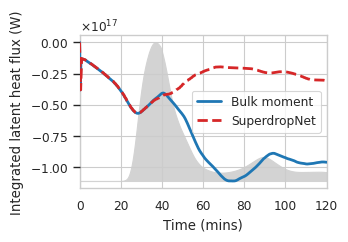

In [15]:
compare_grid_vert_int_content_time('hfls', ylabel='Integrated latent heat flux (W)', background='bulk-moment-rain')

./paper_plots/mean_hfls_warm_bubble_fortran_warm_bubble_cffi.pdf


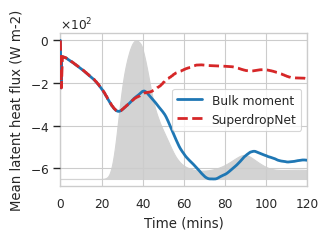

In [16]:
# FIG 4b
compare_grid_vert_mean_content_time('hfls', ylabel='Mean latent heat flux (W m-2)', background='bulk-moment-rain')

Specific snow content, cold bubble scenario

./paper_plots/int_qsvi_cold_bubble_fortran_cold_bubble_cffi.pdf


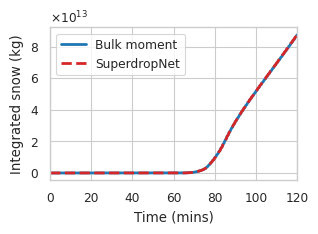

In [17]:
compare_grid_vert_int_content_time('qsvi', exp_bulkmoment='cold_bubble_fortran', exp_superdropnet='cold_bubble_cffi', ylabel='Integrated snow (kg)', ls2='--')

./paper_plots/mean_qsvi_cold_bubble_fortran_cold_bubble_cffi.pdf


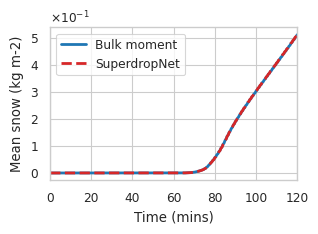

In [18]:
# FIG 3
compare_grid_vert_mean_content_time('qsvi', exp_bulkmoment='cold_bubble_fortran', exp_superdropnet='cold_bubble_cffi', ylabel='Mean snow (kg m-2)', ls2='--')

## Hovmoller diagrams

In [19]:
def hovmoller_time(value, 
                   exp_bulkmoment='warm_bubble_fortran', 
                   exp_superdropnet='warm_bubble_cffi', 
                   exp_root='/work/ka1176/caroline/gitlab/icon-aes/experiments/',
                   cmap='viridis',
                   symmetric_cmap=False,
                   max_height=10000,
                   background=None,
                   textcolor=None,
                   clabel=None,
                   use_scn=True):
    '''
    Hovmoller diagram (value vs time) for two experiments
    
    Args:
      value (str): quantity to plot
      exp_bulkmoment: the bulk-moment experiment (default: warm_bubble_fortran)
      exp_superdropnet: the SuperdropNet experiment (default: warm_bubble_cffi)
      exp_root: the experiment root directory (default: /work/ka1176/caroline/gitlab/icon-aes/experiments/)
      cmap: matplotlib colormap
      symmetric_cmap: set vmin = -max(abs(vmin, vmax)) if True (default: False)
      max_height: max geometric height
      background (str): choice of 'bulk-moment-rain' 'superdropnet-rain' None
      textcolor: choice of annotation text color for scheme (default: None - no text)
      clabel (str): colorbar clabel, if None construct from data
      use_scn (bool): Use scientific notation on colorbar formatter (default: True)

    '''

    fig, ax = plt.subplots(1, 2, figsize=figsize_double, sharex=True, sharey=True)
    
    ax[0].grid(False)
    ax[1].grid(False)
    
    infile_fortran = os.path.join(exp_root, exp_bulkmoment, f'{exp_bulkmoment}_atm_3d_ml_20080801T000000Z.nc')
    infile_cffi    = os.path.join(exp_root, exp_superdropnet, f'{exp_superdropnet}_atm_3d_ml_20080801T000000Z.nc')
    
    q_fortran = cdo.fldmean(input=f'-selname,{value} ' + infile_fortran, returnXArray=value).squeeze()
    q_cffi = cdo.fldmean(input=f'-selname,{value} ' + infile_cffi, returnXArray=value).squeeze()

    time_fortran = get_time_mins(q_fortran)
    time_cffi    = get_time_mins(q_cffi)
    
    zg_fortran = get_geometric_height(infile_fortran)
    zg_cffi    = get_geometric_height(infile_cffi)
    
    if clabel is None:
        clabel = f'Mean {q_fortran.long_name} ({q_fortran.units})'
        
    vmin = min(q_cffi.min(), q_fortran.min())
    vmax = max(q_cffi.max(), q_fortran.max())
    
    if symmetric_cmap:
        vmin = -max(np.abs([vmin, vmax]))
        vmax = +max(np.abs([vmin, vmax]))
    
    # bulk moment scheme
    img = ax[0].imshow(q_fortran.T, aspect='auto', 
                       extent=[time_fortran[0], time_fortran[-1], zg_fortran[-1], zg_fortran[0]], 
                       vmin=vmin, vmax=vmax,
                       cmap=cmap)
    ax[0].set_ylim(0, max_height)
    ax[0].set_xlabel('Time (minutes)')
    ax[0].set_ylabel('Geometric height (m)')
    ax[0].set_xticks([0, 20, 40, 60, 80, 100, 120])
    
    if textcolor:
        ax[0].text(0.01, 0.99, l_bulk, transform=ax[0].transAxes, va='top', ha='left', color=textcolor)
    
    # superdropnet
    img = ax[1].imshow(q_cffi.T, aspect='auto', 
                       extent=[time_fortran[0], time_fortran[-1], zg_fortran[-1], zg_fortran[0]], 
                       vmin=vmin, vmax=vmax,
                       cmap=cmap)
    ax[1].set_ylim(0, max_height)
    ax[1].set_xlabel('Time (minutes)')
    
    if use_scn:
        plt.colorbar(img, ax=ax, label=clabel, format=formatter)
    else:
        plt.colorbar(img, ax=ax, label=clabel)
    
    if textcolor:
        ax[1].text(0.01, 0.99, l_snet, transform=ax[1].transAxes, va='top', ha='left', color=textcolor)
        
    plt.savefig(f'./paper_plots/hovmoller_time_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf', dpi=dpi, bbox_inches='tight')    

In [20]:
def hovmoller_time_diff(value, 
                   exp_bulkmoment='warm_bubble_fortran', 
                   exp_superdropnet='warm_bubble_cffi', 
                   exp_root='/work/ka1176/caroline/gitlab/icon-aes/experiments/',
                   cmap='RdBu',
                   symmetric_cmap=False,
                   max_height=10000,
                   background=None,
                   textcolor=None,
                   clabel=None,
                   use_scn=True):
    '''
    Hovmoller diagram (value vs time) for the diff of two experiments
    
    Args:
      value (str): quantity to plot
      exp_bulkmoment: the bulk-moment experiment (default: warm_bubble_fortran)
      exp_superdropnet: the SuperdropNet experiment (default: warm_bubble_cffi)
      exp_root: the experiment root directory (default: /work/ka1176/caroline/gitlab/icon-aes/experiments/)
      cmap: matplotlib colormap
      symmetric_cmap: set vmin = -max(abs(vmin, vmax)) if True (default: False)
      max_height: max geometric height
      background (str): choice of 'bulk-moment-rain' 'superdropnet-rain' None
      textcolor: choice of annotation text color for scheme (default: None - no text)
      clabel (str): colorbar clabel, if None construct from data
      use_scn (bool): Use scientific notation on colorbar formatter (default: True)

    '''

    fig, ax = plt.subplots(1, 1, figsize=figsize_single, sharex=True, sharey=True)
    
    ax.grid(False)
    
    infile_fortran = os.path.join(exp_root, exp_bulkmoment, f'{exp_bulkmoment}_atm_3d_ml_20080801T000000Z.nc')
    infile_cffi    = os.path.join(exp_root, exp_superdropnet, f'{exp_superdropnet}_atm_3d_ml_20080801T000000Z.nc')
    
    q_fortran = cdo.fldmean(input=f'-selname,{value} ' + infile_fortran, returnXArray=value).squeeze()
    q_cffi = cdo.fldmean(input=f'-selname,{value} ' + infile_cffi, returnXArray=value).squeeze()

    time_fortran = get_time_mins(q_fortran)
    time_cffi    = get_time_mins(q_cffi)
    
    zg_fortran = get_geometric_height(infile_fortran)
    zg_cffi    = get_geometric_height(infile_cffi)
    
    if clabel is None:
        clabel = f'Mean {q_fortran.long_name} ({q_fortran.units})'
        
    vmin = np.min(q_fortran - q_cffi)
    vmax = np.max(q_fortran - q_cffi)
    
    if symmetric_cmap:
        vmin = -max(np.abs([vmin, vmax]))
        vmax = +max(np.abs([vmin, vmax]))
    
    # bulk moment scheme
    img = ax.imshow(q_cffi.T - q_fortran.T, aspect='auto', 
                       extent=[time_fortran[0], time_fortran[-1], zg_fortran[-1], zg_fortran[0]], 
                       vmin=vmin, vmax=vmax,
                       cmap=cmap)
    ax.set_ylim(0, max_height)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Geometric height (m)')
    ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
    
    if textcolor:
        ax.text(0.01, 0.99, l_bulk, transform=ax[0].transAxes, va='top', ha='left', color=textcolor)
    
    if use_scn:
        plt.colorbar(img, ax=ax, label=clabel, format=formatter)
    else:
        plt.colorbar(img, ax=ax, label=clabel)
    
    if textcolor:
        ax[1].text(0.01, 0.99, l_snet, transform=ax[1].transAxes, va='top', ha='left', color=textcolor)
        
    print(f'./paper_plots/hovmoller_time_diff_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf')
    plt.savefig(f'./paper_plots/hovmoller_time_diff_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf', dpi=dpi, bbox_inches='tight')    

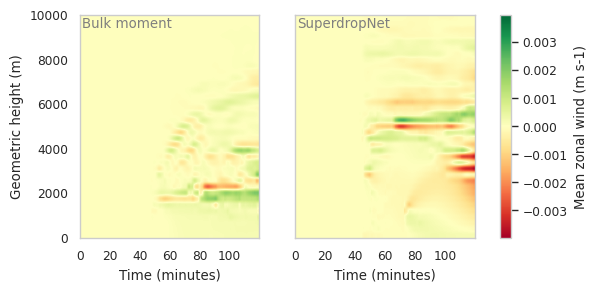

In [21]:
hovmoller_time('ua', symmetric_cmap=True, cmap='RdYlGn', textcolor='C7', use_scn=False, clabel='Mean zonal wind (m s-1)')

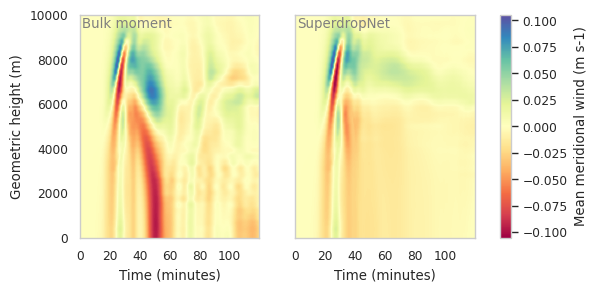

In [22]:
# FIG 5
hovmoller_time('va', symmetric_cmap=True, cmap='Spectral', textcolor='C7', use_scn=False, clabel='Mean meridional wind (m s-1)')

In [23]:
def vertical_profile_by_time(value, 
                   exp_bulkmoment='warm_bubble_fortran', 
                   exp_superdropnet='warm_bubble_cffi', 
                   exp_root='/work/ka1176/caroline/gitlab/icon-aes/experiments/',
                   max_height=10000,
                   dheight=2000,
                   times=['00:00:00', '00:20:00', '00:40:00', '01:00:00', '01:20:00', '01:40:00'], 
                   background=None,
                   textcolor=None,
                   clabel=None,
                   xmin=None,
                   xmax=None,
                   use_scn=True,
                             ls1='-', ls2='--',
                            kg_to_g=False):
    '''
    Vertical profile for two experiments organized in panels by time stamp
    
    Args:
      value (str): quantity to plot
      exp_bulkmoment: the bulk-moment experiment (default: warm_bubble_fortran)
      exp_superdropnet: the SuperdropNet experiment (default: warm_bubble_cffi)
      exp_root: the experiment root directory (default: /work/ka1176/caroline/gitlab/icon-aes/experiments/)
      cmap: matplotlib colormap
      symmetric_cmap: set vmin = -max(abs(vmin, vmax)) if True (default: False)
      max_height: max geometric height
      dheight: plot height tick spacing
      times (list): timestamps to use
      background (str): choice of 'bulk-moment-rain' 'superdropnet-rain' None
      textcolor: choice of annotation text color for scheme (default: None - no text)
      clabel (str): colorbar clabel, if None construct from data
      use_scn (bool): Use scientific notation on colorbar formatter (default: True)
      kg_to_g (bool): Convert to g/kg (default: False)

    '''

    fig, ax = plt.subplots(2, len(times)//2, figsize=figsize_double, sharex=True, sharey=True)
    
    [axx.grid(True) for axx in ax.flatten()]
    
    infile_fortran = os.path.join(exp_root, exp_bulkmoment, f'{exp_bulkmoment}_atm_3d_ml_20080801T000000Z.nc')
    infile_cffi    = os.path.join(exp_root, exp_superdropnet, f'{exp_superdropnet}_atm_3d_ml_20080801T000000Z.nc')
    
    zg_fortran = get_geometric_height(infile_fortran)
    zg_cffi    = get_geometric_height(infile_cffi)

    # time frames
    for i, time, axx in zip(range(len(times)), times, ax.flatten()):
        t_fldmean = cdo.seltime(time, input='-fldmean -selname,' + value + ' ' + infile_fortran, returnXArray=value).squeeze()
        if kg_to_g:
            t_fldmean *= 1e3
        
        if i==0: # label
            axx.plot(t_fldmean, zg_fortran, lw=2, color='C0', label='Bulk moment', ls=ls1)
        else:
            axx.plot(t_fldmean, zg_fortran, lw=2, color='C0', ls=ls1)
        
        if clabel is None:
            clabel = f'Mean {t_fldmean.long_name} ({t_fldmean.units})'
        
        t_fldmean = cdo.seltime(time, input='-fldmean -selname,' + value + ' ' + infile_cffi, returnXArray=value).squeeze()
        if kg_to_g:
            t_fldmean *= 1e3
        
        if i==0: # label
            axx.plot(t_fldmean, zg_cffi, lw=2, color='C3', label='SuperdropNet', ls=ls2)
        else:
            axx.plot(t_fldmean, zg_cffi, lw=2, color='C3', ls=ls2)
        axx.set_ylim(0, max_height)
        axx.set_yticks(np.arange(0, max_height+1, dheight))
        
        if not xmin is None and not xmax is None:
            axx.set_xlim(xmin, xmax)
            
        axx.text(0.97, 0.95, time, transform=axx.transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
    
    # place legend on top
    fig.legend(ncol=2, loc=9)
        
    fig.supylabel('Geometric height (m)', fontsize=10)
    fig.supxlabel(clabel, fontsize=10, y=-0.05)
    #fig.tight_layout()
        
    plt.savefig(f'./paper_plots/vertical_profile_by_time_{value}_{exp_bulkmoment}_{exp_superdropnet}.pdf', dpi=dpi, bbox_inches='tight')    

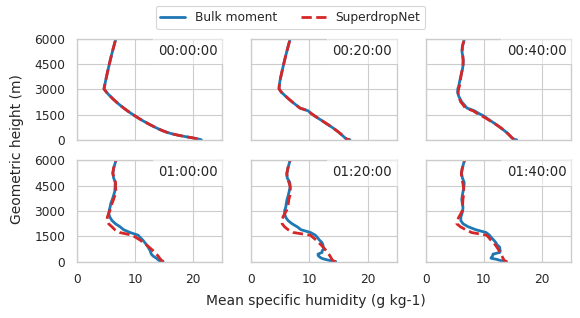

In [24]:
# FIG 6
vertical_profile_by_time('hus', max_height=6000, dheight=1500, xmin=0, xmax=0.025e3, kg_to_g=True, clabel='Mean specific humidity (g kg-1)')

In [25]:
def vertical_profile_ratio_by_time(value1, value2,
                   exp_bulkmoment='warm_bubble_fortran', 
                   exp_superdropnet='warm_bubble_cffi', 
                   exp_root='/work/ka1176/caroline/gitlab/icon-aes/experiments/',
                   max_height=10000,
                   dheight=2000,
                   times=['00:00:00', '00:20:00', '00:40:00', '01:00:00', '01:20:00', '01:40:00'], 
                   background=None,
                   textcolor=None,
                   clabel=None,
                   xmin=None,
                   cut=1e-24,
                   xmax=None,
                                   ls1='-', ls2='--',
                                   kg_to_mug=False,
                   use_scn=True):
    '''
    Vertical profile for two experiments organized in panels by time stamp
    Ratio of two values
    
    Args:
      value (str): quantity to plot
      exp_bulkmoment: the bulk-moment experiment (default: warm_bubble_fortran)
      exp_superdropnet: the SuperdropNet experiment (default: warm_bubble_cffi)
      exp_root: the experiment root directory (default: /work/ka1176/caroline/gitlab/icon-aes/experiments/)
      cmap: matplotlib colormap
      symmetric_cmap: set vmin = -max(abs(vmin, vmax)) if True (default: False)
      max_height: max geometric height
      dheight: plot height tick spacing
      times (list): timestamps to use
      background (str): choice of 'bulk-moment-rain' 'superdropnet-rain' None
      textcolor: choice of annotation text color for scheme (default: None - no text)
      clabel (str): colorbar clabel, if None construct from data
      use_scn (bool): Use scientific notation on colorbar formatter (default: True)
      kg_to_mug (bool): Convert kg to µg (default: False)
    '''

    fig, ax = plt.subplots(2, len(times)//2, figsize=figsize_double, sharex=True, sharey=True)
    
    [axx.grid(True) for axx in ax.flatten()]
    
    infile_fortran = os.path.join(exp_root, exp_bulkmoment, f'{exp_bulkmoment}_atm_3d_ml_20080801T000000Z.nc')
    infile_cffi    = os.path.join(exp_root, exp_superdropnet, f'{exp_superdropnet}_atm_3d_ml_20080801T000000Z.nc')
    
    zg_fortran = get_geometric_height(infile_fortran)
    zg_cffi    = get_geometric_height(infile_cffi)
    
    

    for i, time, axx in zip(range(len(times)), times, ax.flatten()):
        # bulk moment
        tv1 = cdo.seltime(time, input='-selname,' + value1 + ' ' + infile_fortran, returnXArray=value1)
        tv2 = cdo.seltime(time, input='-selname,' + value2 + ' ' + infile_fortran, returnXArray=value2)   
        
        if clabel is None:
            clabel = f'Mean {tv1.long_name} ({tv1.units}) / {tv2.long_name} ({tv2.units})'
       
        tv1 = xr.where(tv1 < cut, 0, tv1, keep_attrs=True)
        plotval = np.sum(tv1/tv2, axis=(0,2))
        if kg_to_mug:
            plotval *= 1e6
        
        if i==0: # label
            axx.plot(plotval, zg_fortran, lw=2, color='C0', label='Bulk moment', ls=ls1)
        else:
            axx.plot(plotval, zg_fortran, lw=2, color='C0', ls=ls1)
                                
        # superdropnet
        tv1 = cdo.seltime(time, input='-selname,' + value1 + ' ' + infile_cffi, returnXArray=value1)
        tv2 = cdo.seltime(time, input='-selname,' + value2 + ' ' + infile_cffi, returnXArray=value2)
        tv1 = xr.where(tv1 < cut, 0, tv1, keep_attrs=True)
        
        plotval = np.sum(tv1/tv2, axis=(0,2))
        if kg_to_mug:
            plotval *= 1e6
        
        if i==0: # label
            axx.plot(plotval, zg_cffi, lw=2, color='C3', label='SuperdropNet', ls=ls2)
        else:
            axx.plot(plotval, zg_cffi, lw=2, color='C3', ls=ls2)
            
        axx.set_ylim(0, max_height)
        axx.set_yticks(np.arange(0, max_height+1, dheight))
        
        if not xmin is None and not xmax is None:
            axx.set_xlim(xmin, xmax)
            
        axx.text(0.97, 0.95, time, transform=axx.transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
    
    # place legend on top
    fig.legend(ncol=2, loc=9)
        
    fig.supylabel('Geometric height (m)', fontsize=10)
    fig.supxlabel(clabel, fontsize=10, y=-0.05)
    #fig.tight_layout()
        
    plt.savefig(f'./paper_plots/vertical_profile_ratio_by_time_{value1}_{value2}_{exp_bulkmoment}_{exp_superdropnet}.pdf', dpi=dpi, bbox_inches='tight')    

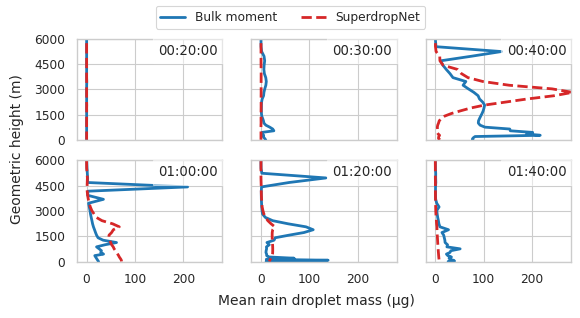

In [26]:
# FIG 7
vertical_profile_ratio_by_time('qr', 'qnr', clabel='Mean rain droplet mass (µg)', kg_to_mug=True, max_height=6000, dheight=1500, cut=1e-20, xmin=-0.00002*1e6, xmax=0.00028*1e6, 
                               times=['00:20:00', '00:30:00', '00:40:00', '01:00:00', '01:20:00', '01:40:00'])

## Benchmark for bridges

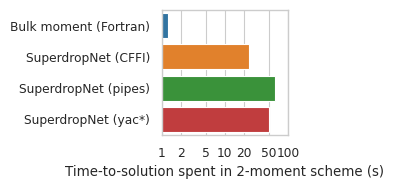

In [27]:
bridges = ['Bulk moment (Fortran)', 'SuperdropNet (CFFI)', 'SuperdropNet (pipes)', 'SuperdropNet (yac*)']
t2mom_max = [1.254, 24.128, 62.597, 49.492]
t2mom_880 = [23.84, 485, 52, 49.492]
df = pd.DataFrame(dict(bridge=bridges, t2mom_max=t2mom_max))

fig=plt.figure(figsize=figsize_single)
sns.barplot(data=df, y='bridge', x='t2mom_max', ax=plt.gca())
ax=plt.gca()
ax.set_ylabel('')
ax.set_xlabel('Time-to-solution spent in 2-moment scheme (s)')
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100])
ax.set_xticklabels([1, 2, 5, 10, 20, 50, 100])

fig.tight_layout()
plt.savefig(f'./paper_plots/iconml-paper-bubble-bench.pdf', bbox_inches='tight')

In [30]:
!pwd

/work/ka1176/caroline/gitlab/2022-03-hereon-python-fortran-bridges/notebooks/paper2023
